In [2]:
## Downloads articles from URLs, and finally outputs a pickle file with event IDs for each article.

# Earliest Date on which alert was received- Feb 26, 2019
import imaplib
import email
import pprint
from bs4 import BeautifulSoup as BS
import newspaper
from newspaper import Article
from pymongo import MongoClient
from  bson import objectid
import itertools
import pickle

from datetime import date, timedelta
import time
from datetime import datetime
import datetime

import pandas as pd
import numpy as np
import psycopg2
import re
import random

In [229]:
def extract_article(url_list):
    #headline = []
    #body = []
    #dates = []
    cache = open("cache_re.pkl",'ab')
    for i, url_one in enumerate(url_list):
        try:
            article = Article(url=url_one)
            article.download()
            article.parse()
            headline_one, body_one, dates_one = article.title, article.text, article.publish_date
            print(i, "-> ", article.publish_date)
        except Exception as e:
            headline_one, body_one, dates_one = '', '', ''
            f_exception = open("base_o/errors_url_re.txt",'a')
            pp = pprint.PrettyPrinter(indent=4, stream=f_exception)
            pp.pprint("Exception with URL:"+url_one)
            pp.pprint(str(e))
            f_exception.close()

        pickle.dump((i, headline_one, body_one, dates_one), cache)
        #headline.append(headline_one)
        #body.append(body_one)
        #dates.append(dates_one)
    return

In [230]:
def get_URLs():
    urls = pd.read_csv('base_o/output.csv')
    urls['feed-date'] = urls['feed-date'].apply(lambda x: datetime.strptime(x, '%b %d %Y'))
    urls = urls.sort_values(by='feed-date')
    urls = urls.reset_index(drop=True)
    return urls

### Download and parse URLs

In [231]:
urls = get_URLs()
len(urls)

26009

### Combine everything into 1 single df

In [ ]:
extract_article(urls['link'])
#id, title, text, art_dates
count=0
google_texts = np.empty(shape=(len(urls),3), dtype=object)
with open('cache_re.pkl', 'rb') as f:
    while f:
        try:
            a = pickle.load(f)
            google_texts[a[0]]=[a[1],a[2],a[3]]
            count += 1
        except:
            f.close()
            break
print(count)

In [ ]:
urls['title'] = google_texts[:,0]
urls['text'] = google_texts[:,1]
urls['published-date'] = google_texts[:,2]

In [237]:
#Write to Cache
# with open('single_cache.pkl', 'wb') as f:
#     pickle.dump(urls, f)

#Read from Cache
with open('single_cache.pkl', 'rb') as f:
    urls = pickle.load(f)

### Cleaning the ones without date - to None

In [2]:
urls['published-date'][urls['published-date'] == ''] = None

### Save in DB

In [263]:
conn = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur = conn.cursor()
cur.execute('''CREATE TABLE google_alerts_chakshu
     (feed_date DATE NOT NULL,
     url TEXT NOT NULL,
     title TEXT NOT NULL,
     text TEXT NOT NULL,
     published_date DATE,
     PRIMARY KEY (feed_date, url));
         ''')
conn.commit()

In [264]:
for i, j in urls.iterrows():
    cur.execute("""INSERT INTO google_alerts_chakshu(feed_date, url, title, text, published_date)
        VALUES (%(a)s, %(b)s, %(c)s, %(d)s, %(e)s)
        ON CONFLICT DO NOTHING;""",
        {'a':j[0], 'b':j[1], 'c':j[2], 'd':j[3], 'e':j[4]} )
conn.commit()
conn.close()

### Fetch Back & Find Events

#### We use a simple rule-based heuristic as descirbed below that checks the captions as well as texts.

In [48]:
def find_event(caption, text):
    if pd.isna(caption):
        caption = ''
    if pd.isna(text):
        text = ''
    c0 = len(re.findall(r"Adhar card|Aadhar|Aadhaar|UIDAI", caption, re.IGNORECASE))
    t0 = len(re.findall(r"Adhar card|Aadhar|Aadhaar|UIDAI", text, re.IGNORECASE))
    c1 = len(re.findall(r"GST|Goods and Services Tax|Goods & Services Tax|Excise Duty", caption, re.IGNORECASE))
    t1 = len(re.findall(r"GST|Goods and Services Tax|Goods & Services Tax|Excise Duty", text, re.IGNORECASE))
    c2 = len(re.findall(r"demonetis|demonetiz|demonitis|demonitiz|denomination note|cash withdrawal|swipe machine|"\
                    "unaccounted money|withdrawal limit|pos machine|fake currency|digital payment|digital "\
                    "transaction|cash transaction|cashless economy|black money|cash crunch|currency switch|"\
                    "long queue|demonetised note|cashless transaction|note ban|currency switch", caption, re.IGNORECASE))
    t2 = len(re.findall(r"demonetis|demonetiz|demonitis|demonitiz|denomination note|cash withdrawal|swipe machine|"\
                    "unaccounted money|withdrawal limit|pos machine|fake currency|digital payment|digital "\
                    "transaction|cash transaction|cashless economy|black money|cash crunch|currency switch|"\
                    "long queue|demonetised note|cashless transaction|note ban|currency switch", text, re.IGNORECASE))
    c3 = len(re.findall(r"loan waiver|farmer loan|farmer suicide|pest infestation|Swaminathan Commission|National "\
                    "Commission on Farmer|kisan|monsoon failure|crop failure|fertili(z|s)ers|Seeds Corporation|farmer|"\
                    "agricultural", caption, re.IGNORECASE))
    t3 = len(re.findall(r"loan waiver|farmer loan|farmer suicide|pest infestation|Swaminathan Commission|National "\
                    "Commission on Farmer|kisan|monsoon failure|crop failure|fertilizers|Seeds Corporation|farmer|"\
                    "agricultural", text, re.IGNORECASE))
    cm, tm = max(c0,c1,c2,c3), max(t0,t1,t2,t3)
    if(cm>=1):
        if cm == c0 and t0 >= 2:
            return 0
        if cm == c1 and t1 >= 2: 
            return 1
        if cm == c2 and t2 >= 2: 
            return 2
        if cm == c3 and t3 >= 2: 
            return 3
    if(tm>=3):
        if tm == t0:
            return 0
        if tm == t1: 
            return 1
        if tm == t2: 
            return 2
        if tm == t3: 
            return 3
    return -1

In [295]:
events=[]
conn = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur = conn.cursor()
cur.execute("SELECT * FROM public.google_alerts_chakshu")
count = 0
while True:
    if count%500 == 0:
        print(count)
    row = cur.fetchone()
    if row == None:
        break
    events.append(find_event(row[2], row[3]))
    count += 1

conn.commit()
conn.close()
# with open("event_ids.pkl", "wb") as fp:
#     pickle.dump(events, fp)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000


### Store Classifies Articles

In [296]:
conn_w = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur_w = conn_w.cursor()
cur_w.execute('''CREATE TABLE google_alerts_classified_chakshu
     (feed_date DATE NOT NULL,
     url TEXT NOT NULL,
     title TEXT NOT NULL,
     text TEXT NOT NULL,
     published_date DATE,
     event_id INT NOT NULL,
     PRIMARY KEY (feed_date, url));
         ''')
conn_w.commit()
conn_w.close()

In [297]:
#write connection
conn_w = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur_w = conn_w.cursor()

#read connection
conn_r = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur_r = conn_r.cursor()

cur_r.execute("SELECT * FROM public.google_alerts_chakshu")

i = 0
row_r = cur_r.fetchone()
while row_r != None:
    cur_w.execute("""INSERT INTO google_alerts_classified_chakshu(feed_date, url, title, text, published_date, event_id)
                     VALUES (%(a)s, %(b)s, %(c)s, %(d)s, %(e)s, %(f)s)
                     ON CONFLICT DO NOTHING;""",
                     {'a':row_r[0], 'b':row_r[1], 'c':row_r[2], 'd':row_r[3], 'e':row_r[4], 'f':events[i]} )
    if i%500 == 0:
        print(i)
    i += 1
    row_r = cur_r.fetchone()

conn_w.commit()
conn_w.close()
conn_r.close()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000


In [298]:
google_records = np.empty(shape = (0, 6))

In [299]:
conn = psycopg2.connect("dbname=google_alerts user=debanjan_final password=Deb@12345 host=10.237.26.159 port=5432")
cur = conn.cursor()

cur.execute("SELECT * FROM public.google_alerts_classified_chakshu")
count = 0

while True:
    row = cur.fetchone()
    if row == None:
        break
    google_records = np.vstack( (google_records, np.array([row[0], row[1], row[2], row[3], row[4], row[5]])) )
    count += 1
conn.close()
print(count)

# feed-date | url | title | text | published-date | event_id
with open("google_records.pkl", "wb") as fp:
    pickle.dump(google_records, fp)

23314


In [3]:
with open("google_records.pkl", "rb") as fp:
    google_records = pickle.load(fp)

In [4]:
google_records[0,0]

datetime.date(2019, 2, 26)

### Validating if event ids are correctly predicted

In [33]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [29]:
start_date = datetime.date(2019, 2, 26)
end_date = datetime.date(2019, 8, 24)
google_records_period = google_records[(google_records[:,0]<=end_date) & (google_records[:,0]>=start_date) ]
testing_event_ids = google_records_period[np.random.choice(google_records_period.shape[0], 100, replace=False), :]

In [30]:
testing_event_ids = pd.DataFrame(data=testing_event_ids, columns=['feed-date', 'url', 'title', 'text', 'published-date', 'predicted'])

In [31]:
testing_event_ids.to_csv('testing_event_ids.csv', index=False)

In [61]:
#len(google_records_period)

len(google_records_period[(google_records_period[:,4] == None) & (google_records_period[:,5] != -1)])
#len(google_records_period[google_records_period[:,5] != -1])

3990

In [33]:
data = pd.read_csv('testing_event_ids.csv')

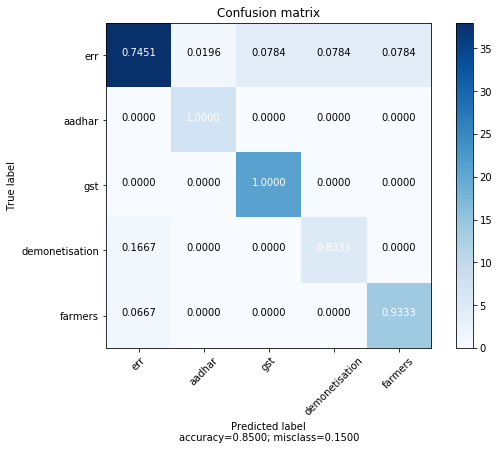

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( data['actual'] , data['predicted'])
plot_confusion_matrix(cm,['err','aadhar','gst','demonetisation','farmers'], normalize=True)

In [31]:
### Re validating

In [49]:
data = pd.read_csv('testing_event_ids.csv')
data1=data
data1['re'] = [-2]*len(data1)

In [50]:
for i, act in enumerate(data1['actual']):
    #if i==49:
    #    from IPython import embed; embed()
    #print(i)
    #print(data1['title'][i])
    data1['re'][i] = find_event(data1['title'][i], data1['text'][i])

/Users/chakshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


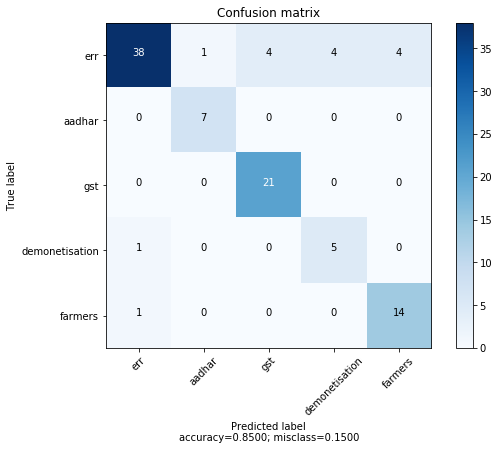

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( data1['actual'] , data1['re'])
plot_confusion_matrix(cm,['err','aadhar','gst','demonetisation','farmers'], normalize=False)